In [6]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
from itertools import cycle
from torchvision import models



In [7]:
# Custom dataset class from the provided training script
class CustomLogoDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        for label, subdir in enumerate(['Fake', 'Genuine']):
            folder_path = os.path.join(self.root_dir, subdir)
            for filename in os.listdir(folder_path):
                if filename.endswith('.jpg') or filename.endswith('.png'):
                    self.images.append(os.path.join(folder_path, filename))
                    self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Image transformations
image_transforms = transforms.Compose([
    transforms.Resize((299, 299)),  # Adjust to your model's input size
    transforms.ToTensor(),
])

# Load the trained model
def load_trained_model(model_path):
    model = models.inception_v3(pretrained=False)
    num_classes = 2
    in_features = model.fc.in_features
    model.fc = torch.nn.Linear(in_features, num_classes)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

# Plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Plot ROC curve
def plot_roc_curve(fpr, tpr, roc_auc):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Plot Precision-Recall curve
def plot_precision_recall_curve(precision, recall):
    plt.figure()
    plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve')
    plt.legend(loc="lower left")
    plt.show()



In [8]:
# Main function for evaluation
def evaluate_model(test_loader, model, device):
    y_true = []
    y_pred = []
    y_scores = []

    model = model.to(device)
    model.eval()

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_scores.extend(outputs.cpu().numpy()[:, 1])

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)
    plot_confusion_matrix(cm, ['Fake', 'Genuine'])
    
    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['Fake', 'Genuine']))

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plot_roc_curve(fpr, tpr, roc_auc)

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    plot_precision_recall_curve(precision, recall)

    



In [9]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare the dataset and dataloader
test_dataset = CustomLogoDataset('FakeReal Logo Detection dataset/test', transform=image_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


d:\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
d:\Python\Python39\lib\site-packages\torchvision\models\inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


Confusion Matrix:
[[78 32]
 [ 1 54]]


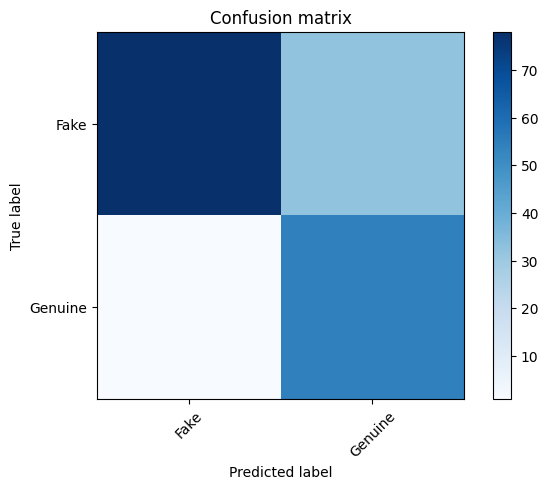


Classification Report:
              precision    recall  f1-score   support

        Fake       0.99      0.71      0.83       110
     Genuine       0.63      0.98      0.77        55

    accuracy                           0.80       165
   macro avg       0.81      0.85      0.80       165
weighted avg       0.87      0.80      0.81       165



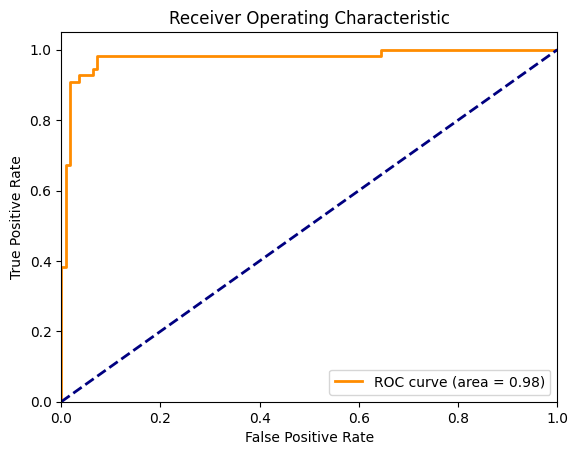

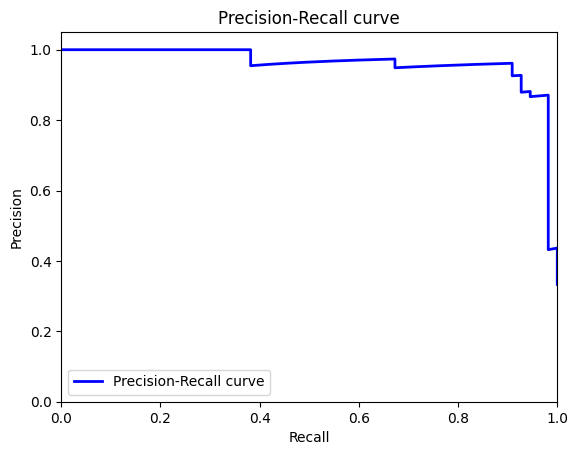

In [10]:

# Load and evaluate the model
model_path = 'inception_fake_real_logo_detection_model_second.pth'
model = load_trained_model(model_path)
evaluate_model(test_loader, model, device)
